# Application of Variational Monte Carlo on large number of spins, N = 50



In [47]:
# Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator

from scipy.linalg import eigh_tridiagonal
from copy import deepcopy

#this is the way to import qutip
#from qutip import *
from numba import njit
import time 
import random
import itertools
import sys
from copy import deepcopy


from scipy.optimize import curve_fit

### Distance Matrix for initialization 

In [22]:
def nextElementOf(k ,L):
    """
        Computes the index of the next spin when a current index is given.
        
        Parameters
        ----------
        k : int
            index of the current spin 
        L : int
            Number of spins in 1d lattice
            
        Returns
        -------
        (k+1)%L : index of the next spin
        """
    # with PBC conditions
    return (k+1)%L

In [24]:
def compute_distance_matrix(nn):
    """
        Computes spin jastrow factor v_ij = ln((d_ij)^2) depends parametrically on the cord-distance d_ij
        between 2 sites given by d_ij = 2*sin(pi*abs(i-j)/L).  
        
        Parameters
        ----------
        nn : int
            Number of spins in 1d lattice 
            
        Returns
        -------
        distance_matrix : matrix of dimension nn x nn
        """
    
    distance_matrix = np.zeros((nn,nn))
    for ii in range(1, nn):
        for jj in range(ii):
            distance_matrix[ii, jj] = 2.0*np.log(abs(np.sin(np.pi*abs(float(ii-jj))/nn)))
            
    return distance_matrix 

def compute_matrix_products_spins(vec):
    """
        Computes the products of spins.
        Parameters
        ----------
        vec : numpy 1D array with elements being +1 or -1
              Single configuration of spins 
            
        Returns
        -------
        matrix_products_spins : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        """

    nn = len(vec)
    matrix_products_spins = np.zeros((nn,nn))
    for ii in range(1, nn):
        for jj in range(ii):
            matrix_products_spins[ii,jj] = vec[ii]*vec[jj]
    
    return matrix_products_spins

In [25]:
def wfRatio( x, k, alpha, v, sMatrix, h, updateS = False):
    """
        Computes the wave function ratio where wf is given by signM(x) * exp( 0.5*alpha *summ(v_ij*2S_i*2S_j)).
        This function calculates the ratio ψ(x')/ψ(x), where x' is the configuration obtained from x
        by flipping spin k and spin k+1.

        Parameters
        ----------
        x : list/vector of dimension nn, with elements being +1 or -1.
        k : int
            index of the current spin 
        alpha : float
            Variational parameter
        v  : numpy 2D array, float
            Spin Jastrow factor computed from defn compute_distance_matrix(nn)
        sMatrix  : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        h  : float
            external magnetic field
        updateS : bool
            sMatrix gets updated when True.
            
        Returns
        -------
        signM_ratio*np.exp(alpha*2.0*expSum) : float
                                              ratio of wf with new configuration and old configuration
        sMatrix : numpy 2D array, int
                  updated spin-spin product matrix  
        """

    L = len(x) #unsigned L = x.n_elem;
    kNext = nextElementOf(k, L)
    #   Set the ratio of the M signs << "Energy (per site) = " 
    signM_ratio = -1
    #    Do the (half) sums in the ratio of the exponentials 
    expSum = 0.0

    #     i = k 
    for j in range(k):
        if j != kNext:            
            expSum += -v[k,j]*sMatrix[k,j]

    #     i = kNext 
    for j in range(kNext):
        if j != k:            
            expSum += -v[kNext,j]*sMatrix[kNext,j]


    #    j = k 
    for i in range(k+1, L):
        if i != kNext:
            expSum += -v[i,k]*sMatrix[i,k]

    #    j = kNext 
    for i in range(kNext+1, L):
        if i != k:
             expSum += -v[i,kNext]*sMatrix[i,kNext]


    #  Update sMatrix if required 
    if updateS == True:
        #  i = k 
        for j in range(k):
            if j != kNext:
                sMatrix[k,j] *= -1

        for j in range(kNext):
            if j != k:
                sMatrix[kNext,j] *= -1

        # j = k 
        for i in range( k+1, L):
            if i != kNext:
                sMatrix[i,k] *= -1

        # j = kNext
        for i in range(kNext+1, L):
            if i != k:
                sMatrix[i,kNext] *= -1

    return signM_ratio*np.exp(alpha*2.0*expSum), sMatrix

In [26]:
def localEnergy(x, alpha, v, sMatrix, h):
    """
        This function calculates the local energy.
        The calculation is achieved by first getting the
          contributions from x'!=x, and then x'=x.

        Parameters
        ----------
        x : list/vector of dimension nn, with elements being +1 or -1.
        alpha : float
            Variational parameter
        v  : numpy 2D array, float
            Spin Jastrow factor computed from defn compute_distance_matrix(nn)
        sMatrix  : matrix of dimension nn x nn, whose elements are simply products of S_i and S_j
        h  : float
            external magnetic field
            
        Returns
        -------
        elocal : float
                 local energy
        """
    #    Initialize the required variables
    eLocal = 0.0
    eBuffer = 0.0
    L = len(x)#x.n_elem;
    kNext = 0
        
    # Add the contribution from x'!=x and calculate nPairs 
    for k in range(L):
        kNext = nextElementOf(k, L);
        if x[k] != x[kNext]: 
            eBuffer, sMatrix = wfRatio( x, k, alpha, v, sMatrix, False)
            eLocal += eBuffer

    eLocal = 0.5*eLocal

    #adding contribution x'==x
    for k in range(L):
            eLocal += 0.5*0.5*x[k]*x[nextElementOf(k, L)]
    return eLocal


In [28]:
# get an initila configuration by fixing Sz
def fix_Sz(nn, count):
    # select a random list from list of lists which is now our initial configuration.
    nums = np.ones(nn,dtype=int)
    nums[:count] = -1
    np.random.shuffle(nums)
    return nums

In [32]:
def main( L = 10, LenSim = 1000000,  h=0 , alpha_min  =0.15, alpha_max = 0.405, alpha_step = 0.01, place_one=1):
    """
        This function begins the Variational Monte carlo Simulation. 

        Parameters
        ----------
        L  : int
            Number of spins in 1D lattice
        LenSim : int
            Number of iterations for Monte carlo
        h  : float
            external magnetic field
        alpha_min, alpha_max, alpha_step  : float
             range of parameter values   
        place_one  : int (shouldn't be greater than L+1)     
             number of 1's to be placed in list of -1's of size L.
             
        Returns
        -------
        M : list of float
            Staggered magnetization for every value of alpha
        alphaRange : list of float
            range of parameter values 
        E: list of float
           ground state energy values for different values of parameter alpha
        ((cpu1 - cpu0)/60) : list of float
            CPU time taken to execute the full simulation
        
        """

    
    #Timer
    cpu0 = time.time()
    
    #Sys simulation param
    
    alphaRange = np.arange(alpha_min, alpha_max, alpha_step)
    
    #+ initialization
    xInit = np.zeros((L))
    v = np.zeros((L, L))
    sMatrixInit = np.zeros((L, L))
    ELocal = 0.0
    
    #Initialize the file variables
    alpha_list = []
    Elocal_list = []
    
    #Initialize first values
    # x initialized to up-down-up-down..
    xInit = fix_Sz(L, place_one )#get_init_x(L)
    # v is basically the distance matrix
    v = compute_distance_matrix(L)
    
    #Just the matrix of the products of the spins of x 
    sMatrixInit = compute_matrix_products_spins(xInit)
    
   # print('Performing VMC for the Heisenberg Model')
    
    
    #Do the variational Loop
    #Here we loop on the variational parameter alpha
    
    E = []
    for alphaIdx in range(len(alphaRange)):
        # Assign alpha;
        alpha = alphaRange[alphaIdx]
        #Make a local copy of the initial x and sMatrix 
        x = deepcopy(xInit)
        sMatrix = deepcopy(sMatrixInit)
        
        
        #Calculate the local energy for the first time
        ElocalCumulative = 0.0
        ELocal = localEnergy(x, alpha, v, sMatrix,  h)
        ElocalCumulative += ELocal
        
        
        #Write on file the first configuration
        alpha_list.append(alpha)
        Elocal_list.append(ELocal/L)
        
        #Begin MAIN MC Loop
        # Initialize Metropolis variables
        k = 0
        kNext = 0
        mRatio = 0
        sNew = np.zeros((L, L))
        acc = 0
        
        #print('Cycle progress=')
        for cycle in range(LenSim):
            #Select a new move (i.e. flip k and k+1) 
        
            k = round(random.random()*(L-1))
            kNext = nextElementOf(k, L)
            
            # Do Metropolis only if we flip different spins,
            # because of the constraint on the total spin
            
            if (x[kNext] != x[k]):
                sNew = deepcopy(sMatrix)
                mRatio, sNew = wfRatio(x, k, alpha, v, sNew,h,  True)
                mRatio = pow(mRatio, 2.0)
                
               #if ( (mRatio < 1) ? (ran1(&idum) < mRatio) : 1 )
               
                r = np.random.rand()
                
                if ((r<mRatio and mRatio<1) or (mRatio>1)):                    
                    acc +=1
                    # Update x by ASSUMING we flip two different spins.
                    # The assumption holds because of the "if" that skips
                    # this section if we flip two equal spins.

                    x[k] = -deepcopy(x[k])
                    x[kNext] = -deepcopy(x[kNext])

                    #Update the sMatrix
                    sMatrix = deepcopy(sNew)

                    # Calculate the local energy
                    ELocal = localEnergy(x, alpha, v, sMatrix, h)

             
            #Update the cumulant of the local energy
            ElocalCumulative += ELocal
            
            
      
        E.append(ElocalCumulative/(LenSim*L))
      
    cpu1 = time.time()
    #print('N = %d, h = %.2f, time = %f minutes' %(L,h, (cpu1 - cpu0)/60))
    return E, alphaRange, xInit, ((cpu1 - cpu0)/60) 

In [ ]:
def get_energy_with_field(energies, magnetizations, h_field):
    """
        This function computes F(m) = E(m) - h*m where m = 0.5*sum(all_spins)/(number of spins)
        
        Parameters
        ----------
        energies : float
              np array of all the min energies found for different Initial configurations
        magnetizations : float
              np array of all the m values found for different Initial configurations
        h_field  : float
               value of external magnetic field 
        
        Returns
        -------
        final_energies  :  float
            np array given by the formula in the description.
        """
    
    
    en_arr = np.array(energies)
    
    final_energies = np.array([energy - magn*h_field for energy, magn in zip(en_arr, magnetizations)])
    
    return final_energies


## Run the VMC and Store all Info for L = 50 spins

In [42]:




#nn_part = [2,4,6,8,10,12]
list_dic = []
nn=50
h_field  = 0.
#for nn in nn_part:
m_values = []
E_vs_m   = []
alpha_list = []
xInit_list = []
t_list = []
print("##########################")
print("L = ", nn, "h = ", h_field)
print("##########################")
for i in range(nn+1):


    E,alpha, xInit, t = main(L=nn,LenSim=100000, h=h_field, place_one=i)
    E_min = min(E)
    magn  = 0.5*np.mean(xInit)
    m_values.append(magn)
    E_vs_m.append(E_min)
    t_list.append(t)
    print("place_ones:",i," t:",t)

    optE_alpha = alpha[np.argmin(E)]

    # create a list of optimal alphas where E is min.
    alpha_list.append(optE_alpha)

    xInit_list.append(xInit)

for h_val in np.arange(0, 3.05, 0.05):
    energies_ok = get_energy_with_field(E_vs_m, m_values, h_val)
#         print(energies_ok)
    list_dic.append({"nn": nn, "h_field": h_val, "energy": min(energies_ok),
                    "optimal_alpha":alpha_list[np.argmin(energies_ok)], 
                     "Init_config":str(xInit_list[np.argmin(energies_ok)]),"cpu_time(min)":t_list[np.argmin(energies_ok)]})

    print("nn:", nn, "h_field:", h_val, "energy:", min(energies_ok),
                    "optimal_alpha:",alpha_list[np.argmin(energies_ok)], 
                     "Init_config:",str(xInit_list[np.argmin(energies_ok)]),"cpu_time(min)",t_list[np.argmin(energies_ok)]) 

print("")


##########################
L =  50 h =  0.0
##########################
place_ones: 0  t: 0.03617482582728068
place_ones: 1  t: 0.7268122752507528
place_ones: 2  t: 1.8468329350153605
place_ones: 3  t: 2.8878074129422506
place_ones: 4  t: 4.221304790178935
place_ones: 5  t: 5.868005394935608
place_ones: 6  t: 7.715429890155792
place_ones: 7  t: 9.651838211218516
place_ones: 8  t: 14.40898118019104
place_ones: 9  t: 14.416354548931121
place_ones: 10  t: 15.999503835042317
place_ones: 11  t: 18.159126993020376
place_ones: 12  t: 20.327634247144065
place_ones: 13  t: 22.44458620150884
place_ones: 14  t: 24.367419652144115
place_ones: 15  t: 26.36920946041743
place_ones: 16  t: 28.099710762500763
place_ones: 17  t: 29.916849760214486
place_ones: 18  t: 30.96644896666209
place_ones: 19  t: 33.60036953687668
place_ones: 20  t: 33.35185730457306
place_ones: 21  t: 33.822848216692606
place_ones: 22  t: 34.062971568107606
place_ones: 23  t: 33.80027894179026
place_ones: 24  t: 33.369977072874704

In [44]:
# Store the cpu time data into csv file
Sz_vals = range(-50,52,2)
df_time = pd.DataFrame({"Sz":Sz_vals ,"time":t_list})
df_time.to_csv("Sz_vs_t_L50.csv",index=False)

# Plot Sz vs time, to understand the dependency of configuration with time complexity 

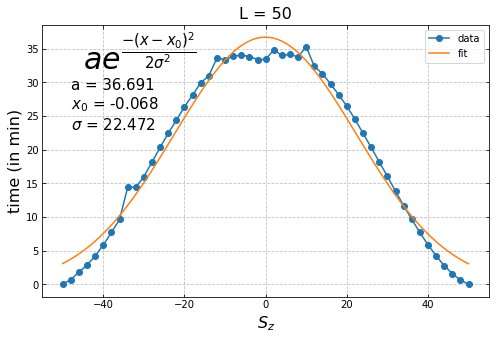

In [77]:
x = np.array(deepcopy(Sz_vals))
y = np.array(deepcopy(t_list))

n = len(x)                          #the number of data


# weighted arithmetic mean (corrected - check the section below)
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])


plt.figure(figsize=(8,5))
plt.plot(Sz_vals, t_list,"o-",label="data" )

x_fit = np.array(range(-50,51,1))
y_fit = Gauss(x_fit,*popt)
plt.plot(x_fit,y_fit,'-',label='fit')



plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')

plt.ylabel("time (in min)",size=16)
plt.xlabel("$S_z$",size=16)
plt.title("L = 50",size=16)
plt.text(-45,32,"$a e^{\\frac{-(x-x_0)^2}{2 \\sigma^2}}$", size=30)
plt.text(-48,23,"a = %.3f\n$x_0$ = %.3f\n$\\sigma$ = %.3f"%(popt[0],popt[1],popt[2]),size=15)
plt.legend(loc="best")
plt.show()

The data points tends to follow gaussian behaviour and thus gaussian fit has been done in the above plot. 

In [58]:
popt # parameters

array([36.69118294, -0.06774138, 22.47192146])

In [ ]:
# store all the data obtained for L=50 into csv file

VMC_energy = pd.DataFrame(list_dic)
VMC_energy.to_csv('Variational_energy_nn50.csv', index = False)
VMC_energy

In [34]:
df_50 = pd.read_csv('Variational_energy_nn50.csv')

In [35]:
df_50

,nn,h_field,energy,optimal_alpha,Init_config,cpu_time(min)
0,50,0.00,-0.442619,0.24,[-1 1 1 -1 1 1 -1 1 1 -1 -1 1 1 -1 -1 ...,33.197513
1,50,0.05,-0.442619,0.24,[-1 1 1 -1 1 1 -1 1 1 -1 -1 1 1 -1 -1 ...,33.197513
2,50,0.10,-0.442907,0.25,[ 1 1 1 1 1 -1 1 -1 -1 -1 1 1 -1 -1 -1 ...,33.244422
3,50,0.15,-0.443907,0.25,[ 1 1 1 1 1 -1 1 -1 -1 -1 1 1 -1 -1 -1 ...,33.244422
4,50,0.20,-0.444907,0.25,[ 1 1 1 1 1 -1 1 -1 -1 -1 1 1 -1 -1 -1 ...,33.244422
...,...,...,...,...,...,...
56,50,2.80,-1.149998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.034681
57,50,2.85,-1.174998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.034681
58,50,2.90,-1.199998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.034681
59,50,2.95,-1.224998,0.15,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,0.034681


# Plot ground state energy vs external field h

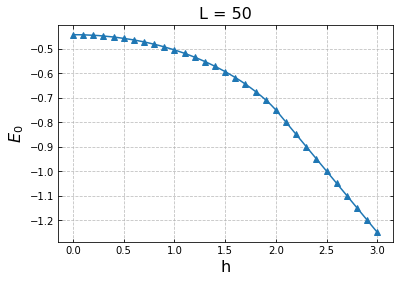

In [41]:
plt.plot(df_50.h_field, df_50.energy,"^-",markevery=2 )



plt.tick_params(direction='in',bottom=True,top=True,left=True,right=True)
plt.grid(linestyle='--',alpha=0.8,which='both')

plt.xlabel("h",size=16)
plt.ylabel("$E_0$",size=16)
plt.title("L = 50",size=16)

plt.show()

In [ ]:
################################################################################################################